## Exercise 9, Image registration

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from IPython.display import clear_output

#import img_as_ubyte from skimage
from skimage import img_as_ubyte

In [3]:
def imshow_orthogonal_view(sitkImage, origin = None, title=None):
    """
    Display the orthogonal views of a 3D volume from the middle of the volume.

    Parameters
    ----------
    sitkImage : SimpleITK image
        Image to display.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    data = sitk.GetArrayFromImage(sitkImage)

    if origin is None:
        origin = np.array(data.shape) // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    data = img_as_ubyte(data/np.max(data))
    axes[0].imshow(data[origin[0], ::-1, ::-1], cmap='gray')
    axes[0].set_title('Axial')

    axes[1].imshow(data[::-1, origin[1], ::-1], cmap='gray')
    axes[1].set_title('Coronal')

    axes[2].imshow(data[::-1, ::-1, origin[2]], cmap='gray')
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

def overlay_slices(sitkImage0, sitkImage1, origin = None, title=None):
    """
    Overlay the orthogonal views of a two 3D volume from the middle of the volume.
    The two volumes must have the same shape. The first volume is displayed in red,
    the second in green.

    Parameters
    ----------
    sitkImage0 : SimpleITK image
        Image to display in red.
    sitkImage1 : SimpleITK image
        Image to display in green.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    vol0 = sitk.GetArrayFromImage(sitkImage0)
    vol1 = sitk.GetArrayFromImage(sitkImage1)

    if vol0.shape != vol1.shape:
        raise ValueError('The two volumes must have the same shape.')
    if np.min(vol0) < 0 or np.min(vol1) < 0: # Remove negative values - Relevant for the noisy images
        vol0[vol0 < 0] = 0
        vol1[vol1 < 0] = 0
    if origin is None:
        origin = np.array(vol0.shape) // 2

    sh = vol0.shape
    R = img_as_ubyte(vol0/np.max(vol0))
    G = img_as_ubyte(vol1/np.max(vol1))

    vol_rgb = np.zeros(shape=(sh[0], sh[1], sh[2], 3), dtype=np.uint8)
    vol_rgb[:, :, :, 0] = R
    vol_rgb[:, :, :, 1] = G

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(vol_rgb[origin[0], ::-1, ::-1, :])
    axes[0].set_title('Axial')

    axes[1].imshow(vol_rgb[::-1, origin[1], ::-1, :])
    axes[1].set_title('Coronal')

    axes[2].imshow(vol_rgb[::-1, ::-1, origin[2], :])
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

## Ex 1

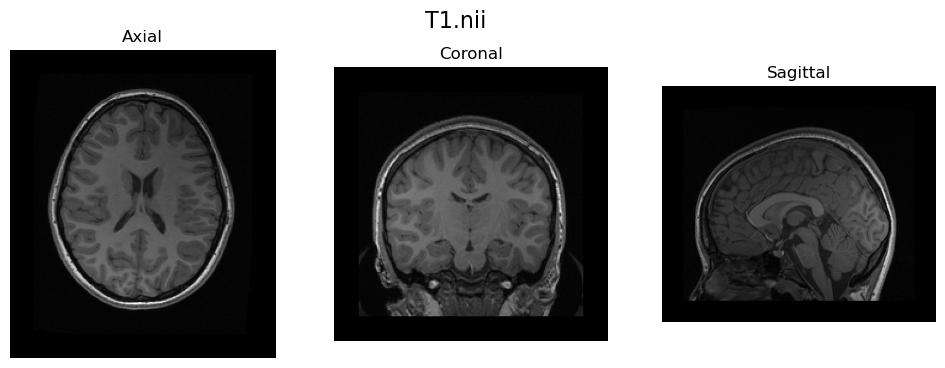

In [5]:
dir_in = 'data/'
vol_sitk = sitk.ReadImage(dir_in + 'ImgT1.nii')

# Display the volume
imshow_orthogonal_view(vol_sitk, title='T1.nii')

In [6]:
import numpy as np

def rotation_matrix(pitch, roll, yaw):
    """
    Return the rotation matrix for the given pitch, roll and yaw angles.

    Parameters
    ----------
    pitch : float
        Pitch angle in degrees.
    roll : float
        Roll angle in degrees.
    yaw : float
        Yaw angle in degrees.

    Returns
    -------
    R : ndarray
        Rotation matrix.
    """
    pitch = np.deg2rad(pitch)
    roll = np.deg2rad(roll)
    yaw = np.deg2rad(yaw)

    Rx = np.array([
        [1, 0, 0, 0],
        [0, np.cos(pitch), -np.sin(pitch), 0],
        [0, np.sin(pitch), np.cos(pitch), 0],
        [0, 0, 0, 1]
    ])
    
    Ry = np.array([
        [np.cos(roll), 0, np.sin(roll), 0],
        [0, 1, 0, 0],
        [-np.sin(roll), 0, np.cos(roll), 0],
        [0, 0, 0, 1]
    ])
    
    Rz = np.array([
        [np.cos(yaw), -np.sin(yaw), 0, 0],
        [np.sin(yaw), np.cos(yaw), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    
    return Rx @ Ry @ Rz
    

In [7]:
affine_1 = rotation_matrix(25, 0, 0)

affine_1

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.90630779, -0.42261826,  0.        ],
       [ 0.        ,  0.42261826,  0.90630779,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [8]:
#Apply the affine transformation to the image

#transform.SetMatrix(rot_matrix.T.flatten())


**Important note if applying the transform to the moving image**
An important consideration it is that ITK transforms store the resampling transform/backward mapping transform (fixed to moving image). And then, internally, it applies the inverse of the transform to the moving image.
This means that we have to pass the inverse matrix of the one we have defined. This is because the transformation is applied to the moving image and not to the fixed image. It is important to consider when we want to apply the transformation to the fixed image.

In [9]:
# Define the roll rotation in radians
angle = 25  # degrees
#pitch_radians = np.deg2rad(angle)

# Create the Affine transform and set the rotation
transform = sitk.AffineTransform(3)

centre_image = np.array(vol_sitk.GetSize()) / 2 - 0.5 # Image Coordinate System
centre_world = vol_sitk.TransformContinuousIndexToPhysicalPoint(centre_image) # World Coordinate System
rot_matrix = rotation_matrix(angle, 0, 0)[:3, :3] # SimpleITK inputs the rotation and the translation separately

transform.SetCenter(centre_world) # Set the rotation centre
transform.SetMatrix(rot_matrix.T.flatten())
#! IMPORTANT, If a more general transformation matrix is applied (no only rotations involved), you should compute the inverse matrix as : 
# transform.SetMatrix(np.linealg.inv(rot_matrix).flatten())

# Apply the transformation to the image
ImgT1_A = sitk.Resample(vol_sitk, transform)

# Save the rotated image
sitk.WriteImage(ImgT1_A, dir_in + 'ImgT1_A.nii')

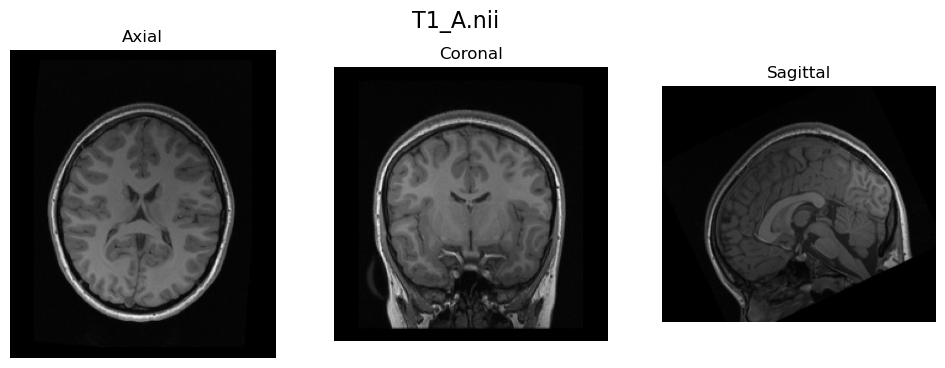

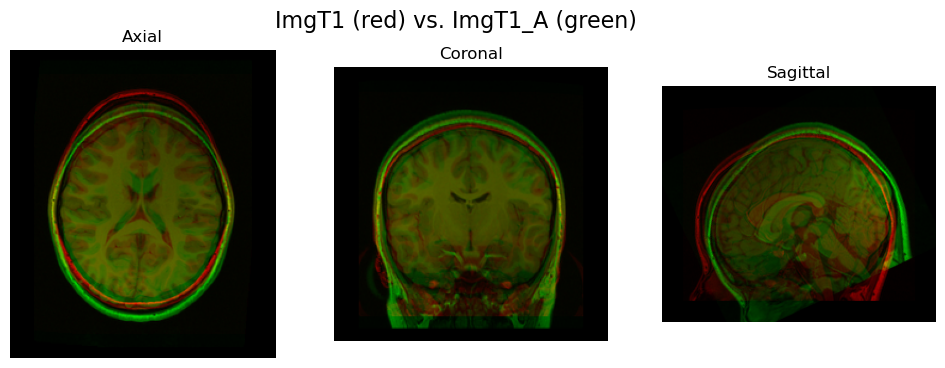

In [10]:
imshow_orthogonal_view(ImgT1_A, title='T1_A.nii')
overlay_slices(vol_sitk, ImgT1_A, title = 'ImgT1 (red) vs. ImgT1_A (green)')

## Regsitration of a moving image to a fixed image
### Ex 5,6 and 7

In [23]:
# Provided code:

# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

def command_iteration(method):
    print(
        f"{method.GetOptimizerIteration():3} "
        + f"= {method.GetMetricValue():10.5f} "
        + f": {method.GetOptimizerPosition()}"
    )

**EX 5 find the best transformation of the moving image to the fixed image, moving image = ImgT1_A.nii and the fixed image ImgT1.nii** The new rotated image is named ImgT1_B.nii and the optimal affine transformation matrix text file is named A1.txt. You can try to modify the metric and optimizer step length.

In [11]:
# Set the registration - Fig. 1 from the Theory Note
R = sitk.ImageRegistrationMethod()

# Set a one-level the pyramid scheule. [Pyramid step]
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the interpolator [Interpolation step]
R.SetInterpolator(sitk.sitkLinear)

# Set the similarity metric [Metric step]
R.SetMetricAsMeanSquares()

# Set the sampling strategy [Sampling step]
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.50)

# Set the optimizer [Optimization step]
R.SetOptimizerAsPowell(stepLength=0.1, numberOfIterations=25)

# Initialize the transformation type to rigid 
initTransform = sitk.Euler3DTransform()
R.SetInitialTransform(initTransform, inPlace=False)

# Some extra functions to keep track to the optimization process 
# R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R)) # Print the iteration number and metric value
R.AddCommand(sitk.sitkStartEvent, start_plot) # Plot the similarity metric values across iterations
R.AddCommand(sitk.sitkEndEvent, end_plot)
R.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))

0

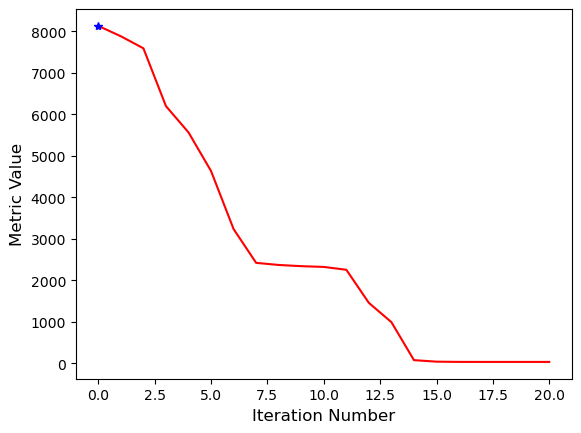

In [12]:
moving_image = ImgT1_A
fixed_image = vol_sitk
# Estimate the registration transformation [metric, optimizer, transform]
tform_reg = R.Execute(fixed_image, moving_image)

# Apply the estimated transformation to the moving image
ImgT1_B = sitk.Resample(moving_image, tform_reg)

# Save 
sitk.WriteImage(ImgT1_B, dir_in + 'ImgT1_B.nii')

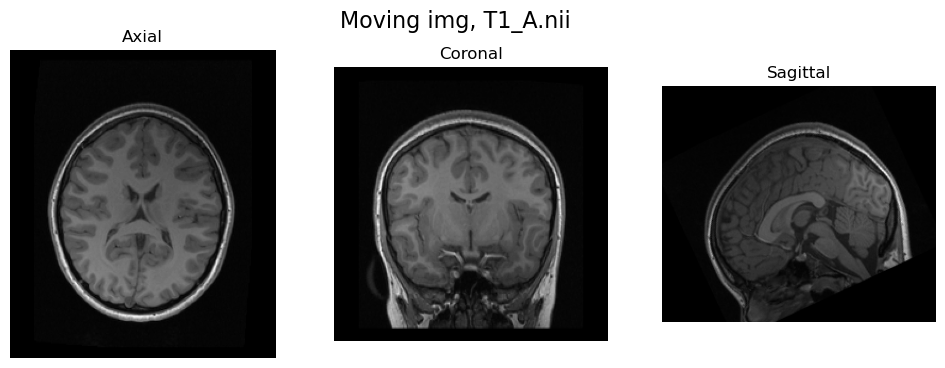

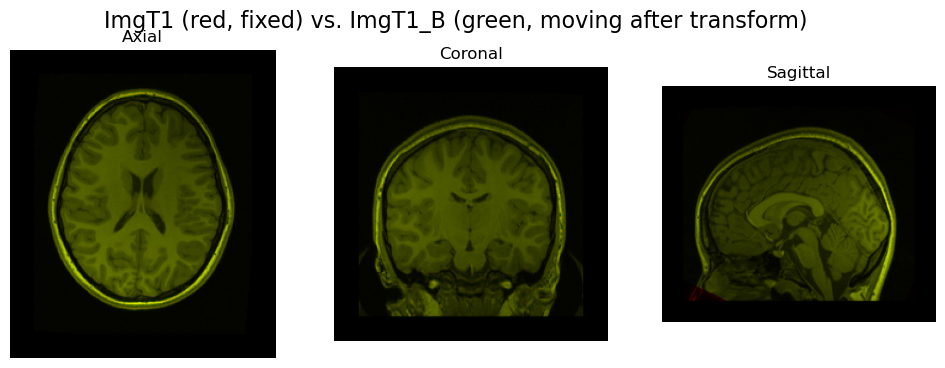

In [13]:
imshow_orthogonal_view(ImgT1_A, title='Moving img, T1_A.nii')
overlay_slices(vol_sitk, ImgT1_B, title = 'ImgT1 (red, fixed) vs. ImgT1_B (green, moving after transform)')

### Exercise 6

### Estimated transformation

In [14]:
estimated_tform = tform_reg.GetNthTransform(0).GetMatrix() # Transform matrix
estimated_translation = tform_reg.GetNthTransform(0).GetTranslation() # Translation vector
params = tform_reg.GetParameters() # Parameters (Rx, Ry, Rz, Tx, Ty, Tz)

#Rounded to 3 decimal places

print(f"Estimated transform matrix: \n{np.round(params, 3)}")

Estimated transform matrix: 
[ 4.3600e-01  0.0000e+00  0.0000e+00 -2.0000e-03  1.1167e+01  3.0630e+01]


In [16]:
#Transform from radians to degrees
np.rad2deg(params[0]) 

24.9987646665663

In [26]:
print(f"Estimated translation {np.round(estimated_translation, 2)}")
print(f"Translation from parameters {np.round(params[3:], 2)}")

Estimated translation [-0.   11.17 30.63]
Translation from parameters [-0.   11.17 30.63]


Very close to 25 degrees, the actual rotation, but what is happening with the translation??

In [17]:
def homogeneous_matrix_from_transform(transform):
    """Convert a SimpleITK transform to a homogeneous matrix."""
    matrix = np.zeros((4, 4))
    matrix[:3, :3] = np.reshape(np.array(transform.GetMatrix()), (3, 3))
    matrix[:3, 3] = transform.GetTranslation()
    matrix[3, 3] = 1
    return matrix

matrix_estimated = homogeneous_matrix_from_transform(tform_reg.GetNthTransform(0))
matrix_applied = homogeneous_matrix_from_transform(transform)

In [24]:
print('Applied transformation matrix: ')
print(np.round(matrix_applied, 2))
print('Estimated registration matrix: ')
print(np.round(matrix_estimated, 2))

Applied transformation matrix: 
[[ 1.    0.    0.    0.  ]
 [ 0.    0.91  0.42  0.  ]
 [ 0.   -0.42  0.91  0.  ]
 [ 0.    0.    0.    1.  ]]
Estimated registration matrix: 
[[ 1.   -0.    0.   -0.  ]
 [ 0.    0.91 -0.42 11.17]
 [-0.    0.42  0.91 30.63]
 [ 0.    0.    0.    1.  ]]


In [42]:
#Or by simply printing the affine transformation matrix after the transpose / inverse step
print(f"Applied transform after inverse \n {np.round(np.linalg.inv(affine_1),2)}")

Applied transform after inverse 
 [[ 1.    0.    0.    0.  ]
 [ 0.    0.91  0.42  0.  ]
 [ 0.   -0.42  0.91  0.  ]
 [ 0.    0.    0.    1.  ]]


We see an unexpected translation of 11.17 and 30.63 in the y and z coordinates

In [35]:
tform_reg.WriteTransform(dir_in + 'A1.tfm')
tform_loaded = sitk.ReadTransform(dir_in + 'A1.tfm')

### Ex 7 

Exercise 7: By default, SimpleITK uses the fixed image’s origin as the rotation center. Change the rotation center to the center of the fixed image and repeat the registration. Compare the results.

Change the rotation center to the center of the image using the following code and repeating the registration (Exercise 5):

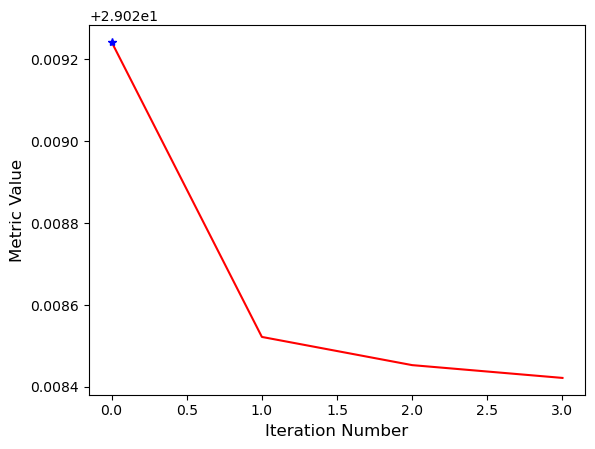

In [44]:
R = sitk.ImageRegistrationMethod()

# Set a one-level the pyramid scheule. [Pyramid step]
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the interpolator [Interpolation step]
R.SetInterpolator(sitk.sitkLinear)

# Set the similarity metric [Metric step]
R.SetMetricAsMeanSquares()

# Set the sampling strategy [Sampling step]
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.50)

# Set the optimizer [Optimization step]
R.SetOptimizerAsPowell(stepLength=0.1, numberOfIterations=25)

initTransform = sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)

R.SetInitialTransform(initTransform, inPlace=False)

# Some extra functions to keep track to the optimization process 
# R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R)) # Print the iteration number and metric value
R.AddCommand(sitk.sitkStartEvent, start_plot) # Plot the similarity metric values across iterations
R.AddCommand(sitk.sitkEndEvent, end_plot)
R.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))

moving_image = ImgT1_A
fixed_image = vol_sitk
# Estimate the registration transformation [metric, optimizer, transform]
tform_reg = R.Execute(fixed_image, moving_image)

# Apply the estimated transformation to the moving image
ImgT1_C = sitk.Resample(moving_image, tform_reg)

# Save 
sitk.WriteImage(ImgT1_C, dir_in + 'ImgT1_C.nii')

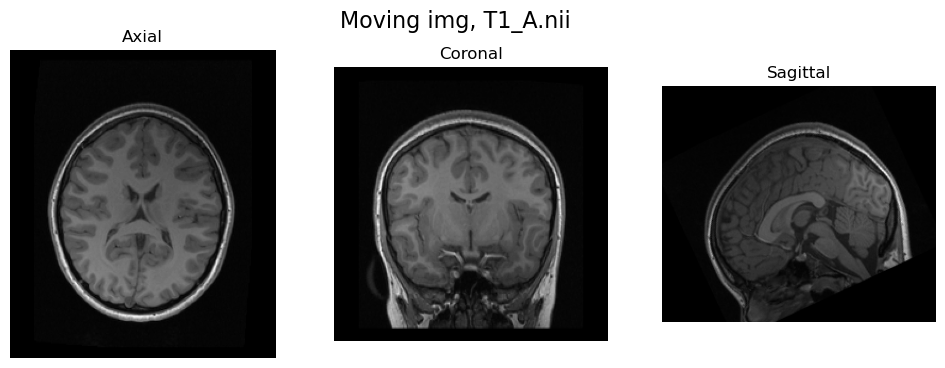

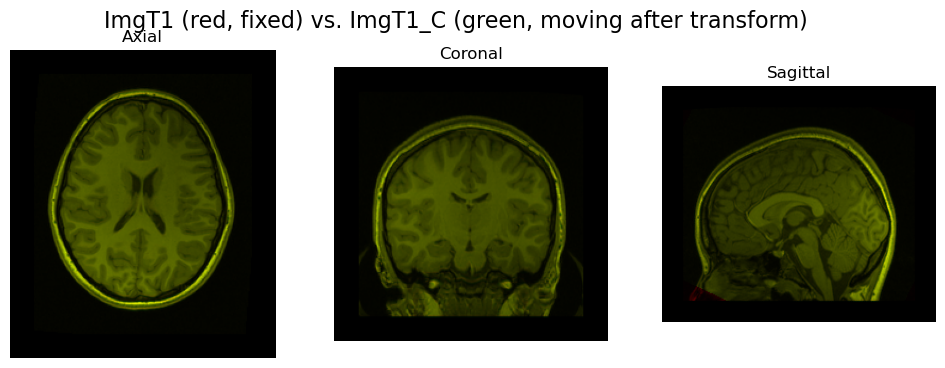

In [46]:
imshow_orthogonal_view(ImgT1_A, title='Moving img, T1_A.nii')
overlay_slices(vol_sitk, ImgT1_C, title = 'ImgT1 (red, fixed) vs. ImgT1_C (green, moving after transform)')

In [47]:
def homogeneous_matrix_from_transform(transform):
    """Convert a SimpleITK transform to a homogeneous matrix."""
    matrix = np.zeros((4, 4))
    matrix[:3, :3] = np.reshape(np.array(transform.GetMatrix()), (3, 3))
    matrix[:3, 3] = transform.GetTranslation()
    matrix[3, 3] = 1
    return matrix

matrix_estimated = homogeneous_matrix_from_transform(tform_reg.GetNthTransform(0))
matrix_applied = homogeneous_matrix_from_transform(transform)

In [48]:
print('Applied transformation matrix: ')
print(np.round(matrix_applied, 2))
print('Estimated registration matrix: ')
print(np.round(matrix_estimated, 2))

Applied transformation matrix: 
[[ 1.    0.    0.    0.  ]
 [ 0.    0.91  0.42  0.  ]
 [ 0.   -0.42  0.91  0.  ]
 [ 0.    0.    0.    1.  ]]
Estimated registration matrix: 
[[ 1.    0.   -0.   -0.  ]
 [-0.    0.91 -0.42  0.  ]
 [ 0.    0.42  0.91  0.  ]
 [ 0.    0.    0.    1.  ]]


Afting changint the center of rotation to that of the initial affine transformation, the translation is now 0.0, 0.0, 0.0 and the rotation is 25.0 degrees, as expected, and the convergence is much faster.

## Generate a series of rotated 3D images
**Exercise 8, 9**

Generate a series of rotated 3D images

Exercise 8: Make four rotation matrices that rotate the ImgT1nii in steps of 60 degrees starting from 60 degrees. Apply the rotation to ImgT1.nii, reslice and store the resulting images as ImgT1_60.nii, ImgT1_120.nii etc. Show in ortho-view that the rotations are applied as expected for each new image.

In [42]:
#
def rotate_save(img, name):
    for i in range(1,6):
        rot_degree = 60*i
        str_name = name + str(rot_degree) + '.nii'
        #rot_m = rotation_matrix(rot_degree, 0, 0)
        #rot_tform = sitk.Euler3DTransform()
        #rot_tform.SetMatrix(rot_m.flatten())
        #rot_img = sitk.Resample(img, rot_tform)
        #sitk.WriteImage(rot_img, dir_in + str_name)
        
        #new code
        transform = sitk.AffineTransform(3)
        centre_image = np.array(img.GetSize()) / 2 - 0.5 # Image Coordinate System
        centre_world = img.TransformContinuousIndexToPhysicalPoint(centre_image) # World Coordinate System
        rot_matrix = rotation_matrix(rot_degree, 0, 0)[:3, :3] # SimpleITK inputs the rotation and the translation separately

        transform.SetCenter(centre_world) # Set the rotation centre
        transform.SetMatrix(rot_matrix.T.flatten())

        # Apply the transformation to the image
        rot_img = sitk.Resample(img, transform)

        # Save the rotated image
        sitk.WriteImage(rot_img, dir_in + str_name)

    

In [43]:
rotate_save(vol_sitk, 'ImgT1_A_rot_')

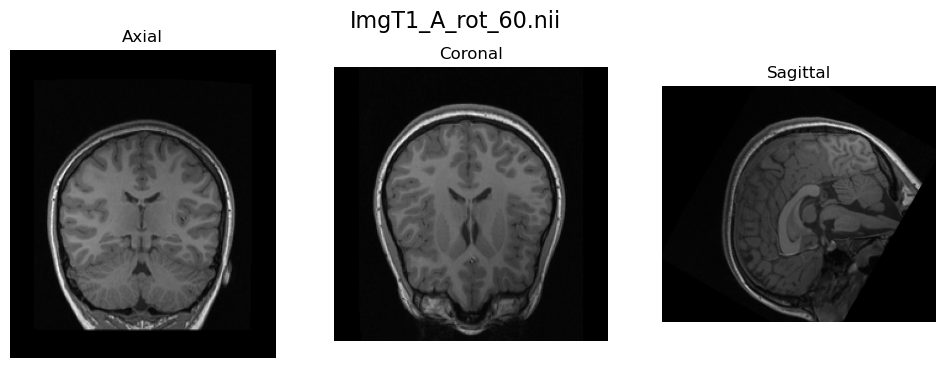

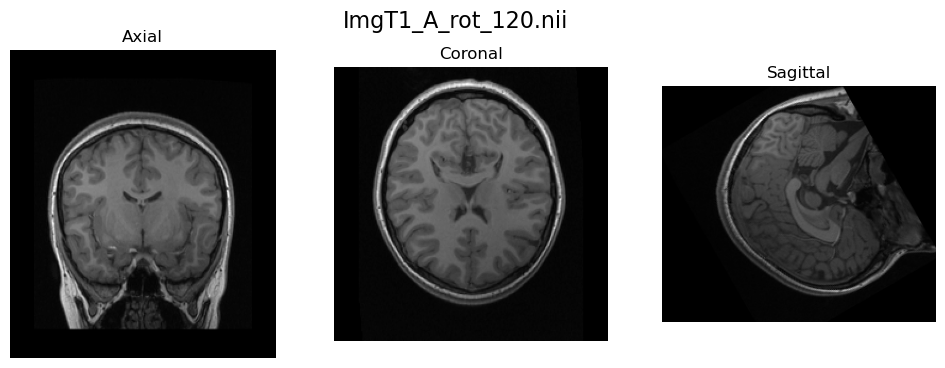

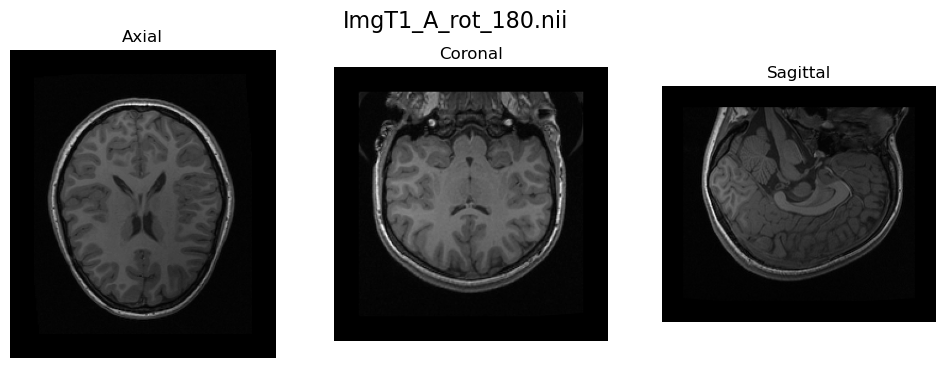

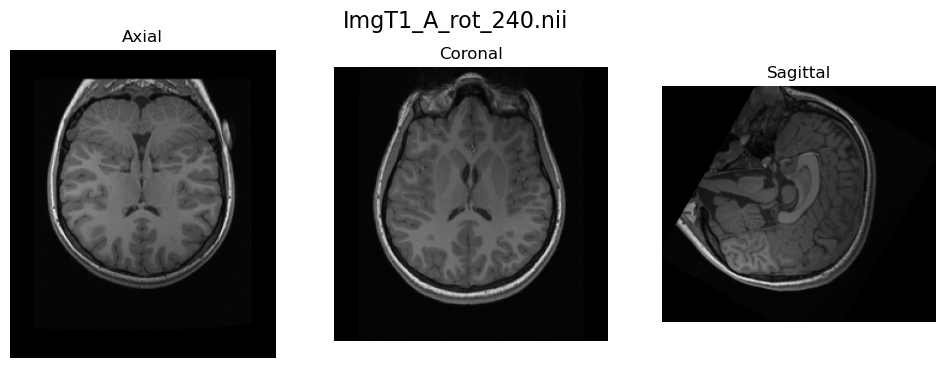

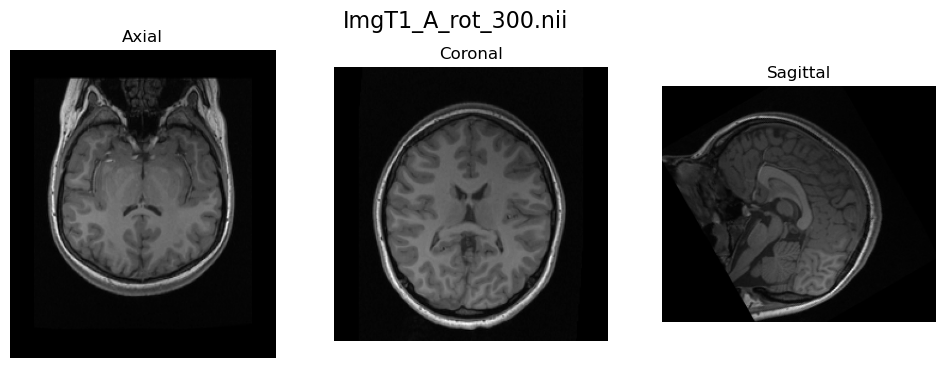

In [49]:
#plot the 5 rotated images
for i in range(1,6):
    rot_degree = 60*i
    str_name = 'ImgT1_A_rot_' + str(rot_degree) + '.nii'
    img = sitk.ReadImage(dir_in + str_name)
    imshow_orthogonal_view(img, title=str_name)

Exercise 9: Use ImgT1_120.nii as the fixed image, and the other three rotated images from Exercise 8 as the moving images. Run the registration to find the affine matrix and include the reslicing procedure for each of the moving images. Show in ortho-view the resliced images and describe what the rotation angles are. Save the transforms with the name "Ex9_60.tfm, Ex10_180.tfm, Ex10_240.tfm" Do the rotations agree with those in Exercise 8?

Note: You will need to change the step length to handle the larger rotations. A too small step would lead to the convergence in a local minimum. A good value may be 10. You may also benefit from modifying the pyramid schedule.

  0 =   30.56749 : (2.094399637448163, -6.0802016238279294e-05, 2.0529512588032952e-05, 0.0014172602432926615, 0.005914825686553377, -0.002279393116838779)
  1 =   30.56675 : (1.0471809081934764, -2.3232448092643493e-05, 3.1015409140038e-05, 0.001275566374494207, 0.0038482614564947426, -0.0007668899428175367)
  2 =   30.56661 : (1.047186587247383, -3.088244161246355e-05, 3.33164274292556e-05, 0.0011812785665310224, 0.003404873738178259, -0.0009024253395486519)
  3 =   30.56656 : (1.047188475353081, -3.178840303124128e-05, 3.1173310364769144e-05, 0.00111777373179995, 0.0034168863012913374, -0.0009278592950835575)
Estimated registration matrix for 60 degrees
[[ 1.   -0.   -0.    0.  ]
 [ 0.    0.5  -0.87  0.  ]
 [ 0.    0.87  0.5  -0.  ]
 [ 0.    0.    0.    1.  ]]
Estimated rotation (deg) for ImgT1_60.nii: 
[ 5.9999e+01 -2.0000e-03  2.0000e-03]
  0 = 13499.31434 : (2.4334742788053187e-05, 6.536529466653009e-05, 0.0, -0.052939282429182444, 0.013809491062276594, 47.9697770887912)
  1 = 62

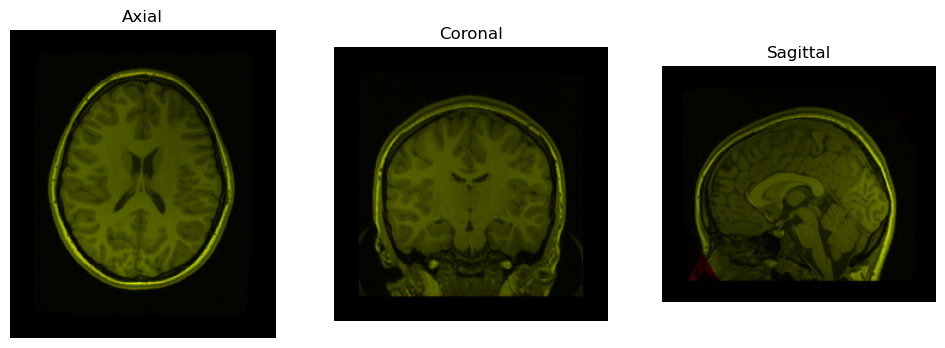

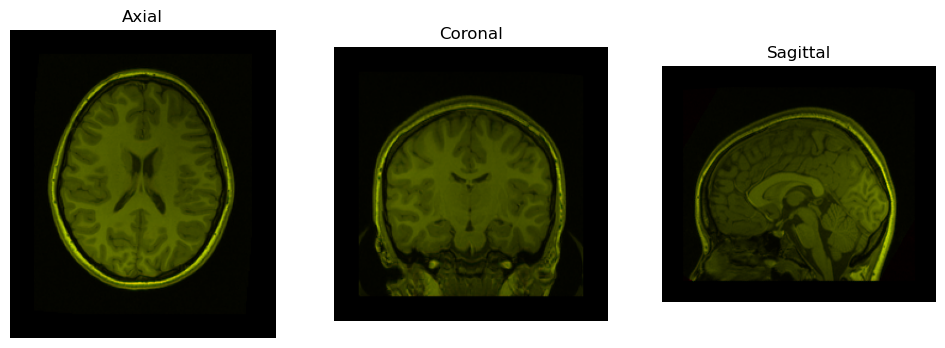

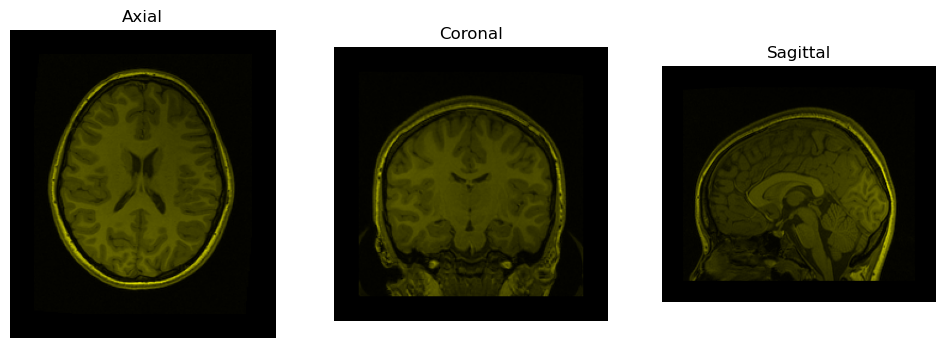

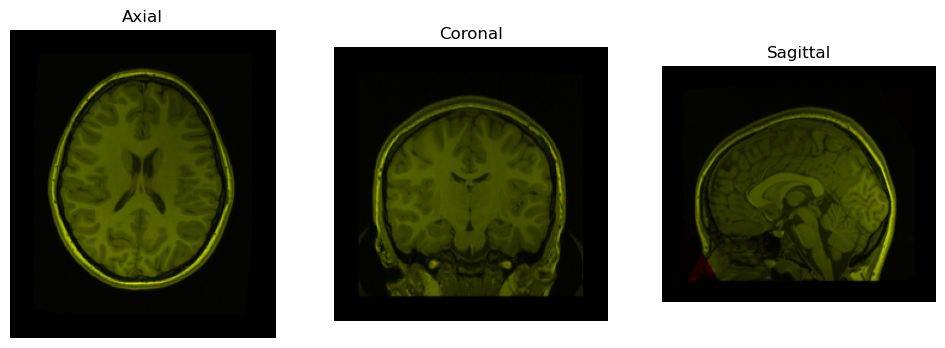

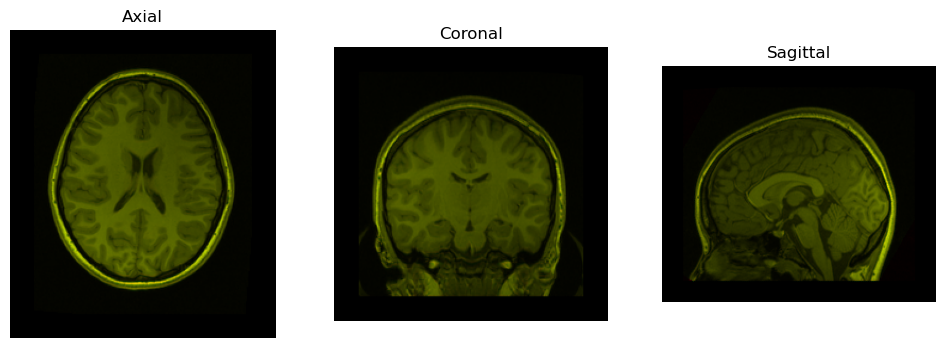

In [52]:
R = sitk.ImageRegistrationMethod()

fixed_image = vol_sitk

# Set a one-level the pyramid scheule. [Pyramid step]
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the interpolator [Interpolation step]
R.SetInterpolator(sitk.sitkLinear)

# Set the similarity metric [Metric step]
R.SetMetricAsMeanSquares()

# Set the sampling strategy [Sampling step]
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.25)

# Set the optimizer [Optimization step]
R.SetOptimizerAsPowell(stepLength=10, numberOfIterations=25)


R.SetInitialTransform(initTransform, inPlace=False)

# Some extra functions to keep track to the optimization process instead of plotting
R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R)) # Print the iteration number and metric value
for i in range(1,6):
    rot_degree = 60*i
    str_name = 'ImgT1_A_rot_' + str(rot_degree) + '.nii'
    moving_image = sitk.ReadImage(dir_in + str_name)
    
    initTransform = sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)
    
    # Estimate the registration transformation [metric, optimizer, transform]
    tform_reg = R.Execute(fixed_image, moving_image)
    tform_reg.WriteTransform(dir_in + f'Ex9_{rot_degree}.tfm')
    

    matrix_estimated = homogeneous_matrix_from_transform(tform_reg.GetNthTransform(0))
    print(f'Estimated registration matrix for {rot_degree} degrees')
    print(np.round(matrix_estimated, 2))
    
    params = tform_reg.GetParameters()
    angles = params[:3]
    print(f'Estimated rotation (deg) for ImgT1_{rot_degree}.nii: ')
    print(np.round(np.rad2deg(angles), 2))

    # Apply the estimated transformation to the moving image
    img_transformed = sitk.Resample(moving_image, tform_reg)

    #Plot
    #imshow_orthogonal_view(img, title=str_name)
    overlay_slices(fixed_image, img_transformed)

The rotated images overlay well with the original image, but the rotation angles are 

- 60 deg: 60 deg:
- 120 deg: -960 deg, = substracting 2 rototations (- 2*360 deg) equals an actual rotation -240 deg which is equavalent to 120 deg
- 180 deg: 900 deg = substracting 2 rotations 720 = 180 deg
- 240 deg: 600 deg ..
- 300 deg: -60 deg 

The rotation angles are not the same as the ones used to generate the images. Likely because of over-stepping during the optimizer, but the result would be equavalent

In [55]:
tform_60 = sitk.ReadTransform(dir_in + 'Ex9_60.tfm')
tform_180 = sitk.ReadTransform(dir_in + 'Ex9_180.tfm')
tform_240 = sitk.ReadTransform(dir_in + 'Ex9_240.tfm')
tform_300 = sitk.ReadTransform(dir_in + 'Ex9_300.tfm')

params = tform_60.GetParameters()
angles = params[:3]
print(f'Estimated rotation (deg): ')
print(np.round(np.rad2deg(angles), 2))

params = tform_180.GetParameters()
angles = params[:3]
print(f'Estimated rotation (deg): ')
print(np.round(np.rad2deg(angles), 2))

params = tform_240.GetParameters()
angles = params[:3]
print(f'Estimated rotation (deg): ')
print(np.round(np.rad2deg(angles), 2))


params = tform_300.GetParameters()
angles = params[:3]
print(f'Estimated rotation (deg): ')
print(np.round(np.rad2deg(angles), 2))

Estimated rotation (deg): 
[60. -0.  0.]
Estimated rotation (deg): 
[900.  -0.  -0.]
Estimated rotation (deg): 
[600.  -0.   0.]
Estimated rotation (deg): 
[-60.   0.  -0.]


## Exercise 10

Often, we wish to combine affine matrixes from a series of images with different registration but apply reslicing only once. The reason is that every time applying reslicing it introduces blurring, and if the image is registered and resliced at each step in a series of rotations, the final image will become very affected by blurring. This we can avoid by first finding the transformation matrix per registration step, then combining them into one matrix, and then applying the reslicing as the final step to the combined affine transformation.

Exercise 10: Use the ImgT1_240.nii as the fixed image and use the ImgT1.nii as the moving image. Make an affine matrix clockwise by combining the estimated transformation and the affine matrix obtained at each rotation step in exercise 10 and apply reslicing. Show in ortho views that the ImgT1.nii after applying the combined affine matrix is registered as expected. Show the combined affine matrix and explains if it applies the expected rotation angle.

**Baseline, normal transform**

  0 = 13807.17449 : (-5.070866635715797e-05, 0.0, -5.569072715188975e-05, 0.0003512010748905665, 32.72657351335252, -31.499943595118836)
  1 = 10458.49507 : (-9.871777154763992, -9.234671954276111e-06, -2.7845363575944875e-05, -0.40088007100948186, 12.606954874850214, 2.289745967624185)
  2 = 8585.75604 : (-17.24237994154424, 0.003549603343333512, -2.7845363575944875e-05, -0.09672059273440264, 11.302868684259133, -6.71730549057517)
  3 = 6707.79608 : (-23.303437751550703, -0.002619000873563473, -2.7845363575944875e-05, -0.045694203821904866, 7.753650652321168, -2.979429364861991)
  4 = 5657.56061 : (-29.246050949590135, 0.0012945633565211415, -0.0006205964078333381, -0.34223473912354163, 2.0115730080420846, -1.1587539527257862)
  5 = 3420.39243 : (-23.076080454322643, 0.02750920711213757, -0.0008238670572171421, -0.26591429492938107, 1.5857024377615843, -3.0490181266497487)
  6 = 3028.34203 : (-22.94312877788169, 0.0026536785807173046, -0.007115988543723084, 0.25560630915855626, -2.589

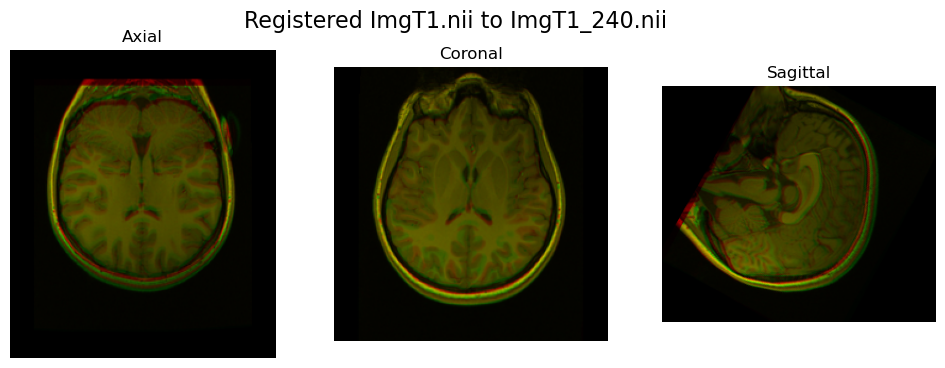

In [58]:
fixed_image = sitk.ReadImage(dir_in + 'ImgT1_A_rot_240.nii')
moving_image = sitk.ReadImage(dir_in + 'ImgT1.nii')

# Set the registration method
R = sitk.ImageRegistrationMethod()
# Set the metric
R.SetMetricAsMeanSquares()

# Set the optimizer
R.SetOptimizerAsPowell(stepLength=10, numberOfIterations=25)

# Set the pyramid scheule
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.20)

# Set the initial transform
R.SetInterpolator(sitk.sitkLinear)

# Some extra functions to help with the iteration
R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

# Set the initial transform 
initTransform =sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)
R.SetInitialTransform(initTransform, inPlace=False)

# Execute the registration
tform_reg = R.Execute(fixed_image, moving_image)
tform_reg.WriteTransform(dir_in + 'Ex10_0.tfm')

params = tform_reg.GetParameters()
angles = params[:3]
print('Estimated rotation (deg) for ImgT1.nii: ')
print(np.round(np.rad2deg(angles), 2))

img_tmp = sitk.Resample(moving_image, tform_reg)
# imshow_orthogonal_view(img_tmp, title='Registered ImgT1.nii to ImgT1_240.nii')
overlay_slices(fixed_image, img_tmp, title='Registered ImgT1.nii to ImgT1_240.nii')

In [59]:
tform_ex10 = sitk.ReadTransform(dir_in + 'Ex10_0.tfm')
params = tform_ex10.GetParameters()
angles = params[:3]
print(f'Estimated rotation (deg): ')
print(np.round(np.rad2deg(angles), 2))

Estimated rotation (deg): 
[-1.32195e+03 -1.80000e-01  3.00000e-02]


In [60]:
-1320, -180, -300

(-1320, -180, -300)

Composite

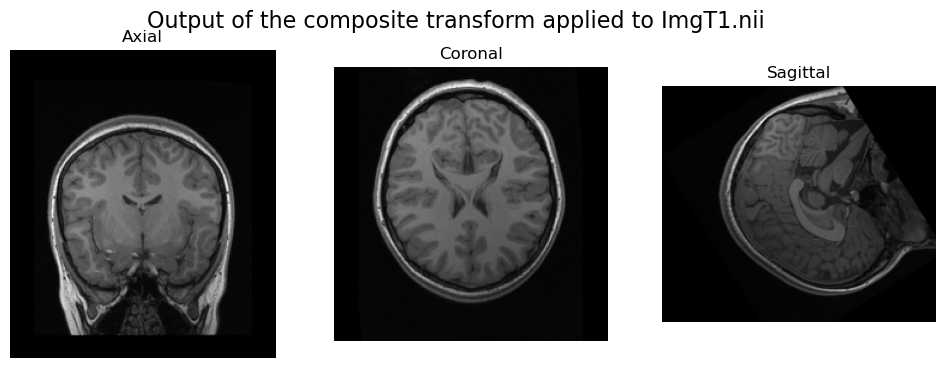

In [61]:
# Load the transforms from file
moving_image = sitk.ReadImage(dir_in + 'ImgT1.nii')

tform_60 = sitk.ReadTransform(dir_in + 'Ex9_60.tfm')
tform_180 = sitk.ReadTransform(dir_in + 'Ex9_180.tfm')
tform_240 = sitk.ReadTransform(dir_in + 'Ex9_240.tfm')
tform_0 = sitk.ReadTransform(dir_in + 'Ex10_0.tfm')

# Concatenate in an ITK way - The last added transform is applied first
tform_composite = sitk.CompositeTransform(3)

tform_composite.AddTransform(tform_240.GetNthTransform(0)) 
tform_composite.AddTransform(tform_180.GetNthTransform(0))
tform_composite.AddTransform(tform_60.GetNthTransform(0))
tform_composite.AddTransform(tform_0.GetNthTransform(0))

img_tmp = sitk.Resample(moving_image, tform_composite)
imshow_orthogonal_view(img_tmp, title='Output of the composite transform applied to ImgT1.nii')

Copied from solution file> THis exercise is so boring..

In [62]:
def composite2affine(composite_transform, result_center=None):
    """
    Combine all of the composite transformation's contents to form an equivalent affine transformation.
    Args:
        composite_transform (SimpleITK.CompositeTransform): Input composite transform which contains only
                                                            global transformations, possibly nested.
        result_center (tuple,list): The desired center parameter for the resulting affine transformation.
                                    If None, then set to [0,...]. This can be any arbitrary value, as it is
                                    possible to change the transform center without changing the transformation
                                    effect.
    Returns:
        SimpleITK.AffineTransform: Affine transformation that has the same effect as the input composite_transform.
    
    Source:
        https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/22_Transforms.ipynb
    """
    # Flatten the copy of the composite transform, so no nested composites.
    flattened_composite_transform = sitk.CompositeTransform(composite_transform)
    flattened_composite_transform.FlattenTransform()
    tx_dim = flattened_composite_transform.GetDimension()
    A = np.eye(tx_dim)
    c = np.zeros(tx_dim) if result_center is None else result_center
    t = np.zeros(tx_dim)
    for i in range(flattened_composite_transform.GetNumberOfTransforms() - 1, -1, -1):
        curr_tx = flattened_composite_transform.GetNthTransform(i).Downcast()
        # The TranslationTransform interface is different from other
        # global transformations.
        if curr_tx.GetTransformEnum() == sitk.sitkTranslation:
            A_curr = np.eye(tx_dim)
            t_curr = np.asarray(curr_tx.GetOffset())
            c_curr = np.zeros(tx_dim)
        else:
            A_curr = np.asarray(curr_tx.GetMatrix()).reshape(tx_dim, tx_dim)
            c_curr = np.asarray(curr_tx.GetCenter())
            # Some global transformations do not have a translation
            # (e.g. ScaleTransform, VersorTransform)
            get_translation = getattr(curr_tx, "GetTranslation", None)
            if get_translation is not None:
                t_curr = np.asarray(get_translation())
            else:
                t_curr = np.zeros(tx_dim)
        A = np.dot(A_curr, A)
        t = np.dot(A_curr, t + c - c_curr) + t_curr + c_curr - c

    return sitk.AffineTransform(A.flatten(), t, c)

In [63]:
affine_composite = composite2affine(tform_composite, centre_world)

# Since we are using just Euler transformations, we can map it to a rigid transform
euler_composite = sitk.Euler3DTransform()
euler_composite.SetMatrix(affine_composite.GetMatrix())
euler_composite.SetTranslation(affine_composite.GetTranslation())
euler_composite.SetCenter(affine_composite.GetCenter())

params = euler_composite.GetParameters()
angles = params[:3]

print(f'Estimated rotation (deg) for the composite transformation: ')
print(np.round(np.rad2deg(angles), 2))

print(f'Estimated homogeneous matrix: ')
print(np.round(homogeneous_matrix_from_transform(euler_composite),2))

Estimated rotation (deg) for the composite transformation: 
[ -58.05  179.86 -179.98]
Estimated homogeneous matrix: 
[[ 1.    0.   -0.    0.1 ]
 [ 0.   -0.53  0.85  2.09]
 [-0.   -0.85 -0.53  2.5 ]
 [ 0.    0.    0.    1.  ]]


The composite result is a rotation of -240 deg  or 120 deg

But you may get a different values of rotation such as [-60, +-180, +-180], which is equivalent to [-240, 0, 0] deg.

**I got -60, 180, -180 , shows the problem of a high number of possible solutions**

## Exercise 11
If the moving image becomes too noisy the registration becomes unstable due to the appealingly many local minima in the cost function - in other words, there exist many sub-optimal solutions to the “optimal” affine matrix. In this case, the registration will be very sensitive to the selection of the hyperparameters such as the step length and the number of iterations. Moreover, depending on the optimizer the estimated affine matrix may be very unstable and will change significantly if we repeat the registration at the same noise level (This is not a critical issue for the Powell optimizer in this problem).

We can increase the noise level in an image by setting the noise standard deviation say to sigma = 200. We use a normal distributed random generator to generate the noise which is added to the image.

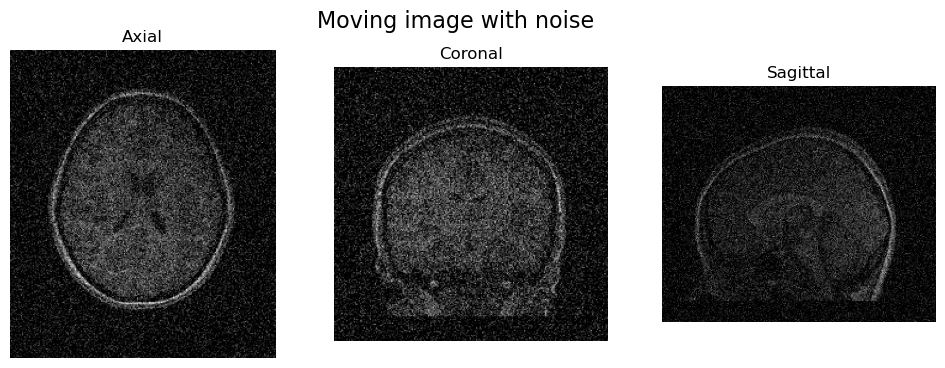

In [64]:
moving_image_noisy = sitk.AdditiveGaussianNoise(moving_image, mean=0, standardDeviation=200)
imshow_orthogonal_view(moving_image_noisy, title='Moving image with noise')

Exercise 11: Use the ImgT1.nii as the fixed image and ImgT1_240.nii as the moving image. Increase the noise level of the moving image and register it to the fixed image and repeat the registration at the same noise-level for different step length. For what standard deviation level and step length does the optimization algorithm cannot find the global minimum? Show the ortho-views of the noisy moving image.

Note: When the noise is added, the optimizer becomes more sensitive to the step length. We suggest to try, at least, standardDeviation=200, and step lengths = [10, 50, 150, 200].

By using the pyramidal multi-resolution registration strategy, we can make the registration of the noisy moving image to the fixed image more robust. Here we use the Gaussian pyramid procedure where we keep the image resolution (i.e., the shrink factor) in the different steps of the pyramid but introduce blurring by using a Gaussian filter at different levels. At the highest level most blurring is added, and we only see the coarse details in the image to be registered. Then, we go to finer and finer levels of details by reducing the blurring factor. The pyramidal procedure is implemented in the registration function and typically three levels are used and we just set the sigma = [3.0, 1.0, 0.0].

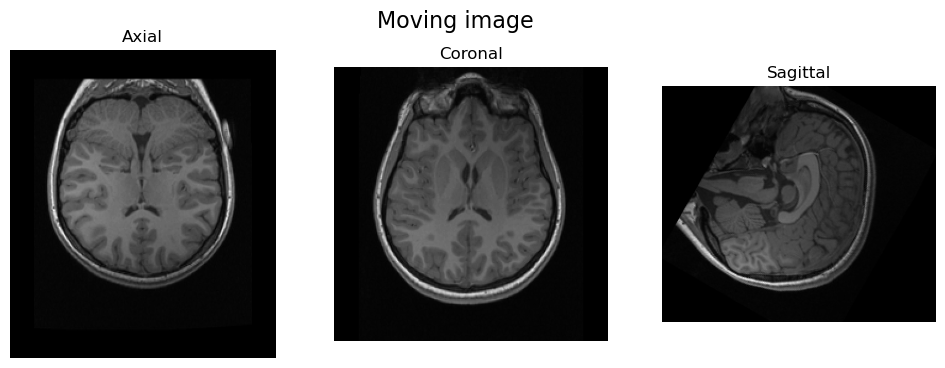

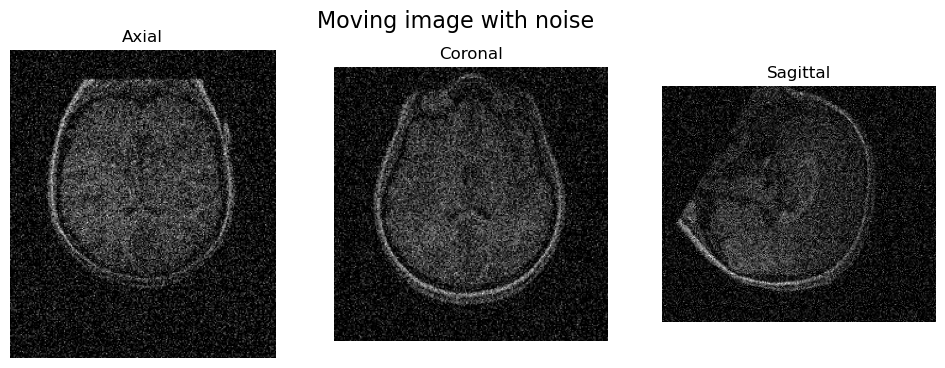

In [66]:
# Load the image
fixed_image = sitk.ReadImage(dir_in + 'ImgT1.nii')
moving_image = sitk.ReadImage(dir_in + 'ImgT1_A_rot_240.nii')

# Add some noise to the moving image
moving_image_noisy = sitk.AdditiveGaussianNoise(moving_image, mean=0, standardDeviation=200)
imshow_orthogonal_view(moving_image, title='Moving image')
imshow_orthogonal_view(moving_image_noisy, title='Moving image with noise')

sitk.WriteImage(moving_image_noisy, 'ImgT1_240_noisy.nii')

  0 = 11660.59458 : (-117.2869198139027, -0.0033345167399105665, 1.4625824555497536e-06, 400.8171489269423, -0.2756588555142868, -0.23656108159859732)
  1 = 11545.36459 : (-58.639723929172405, -0.006106314485674098, 2.568007413071182e-05, 200.46034145563294, -0.06165284268107435, -0.17197985733785293)
  2 = 11345.82304 : (-58.64103317671048, -0.005944152433253232, 0.00018630967269776442, 200.5884796543316, 377.5875504520651, -0.23417124247654422)
  3 =  953.74705 : (-58.64115205144613, -0.0046731503469575, 1.0447240024355755, 200.48518920344196, 196.75325630338426, -15.010919412008109)
  4 =    0.00000 : (-58.63537519398847, -0.005675723113811094, 0.5199095878754811, 200.4004207347455, 192.70634719522428, -7.600285065536863)
Estimated rotation (deg) for ImgT1.nii: 
[-3.359727e+03 -3.000000e-01  2.986000e+01]


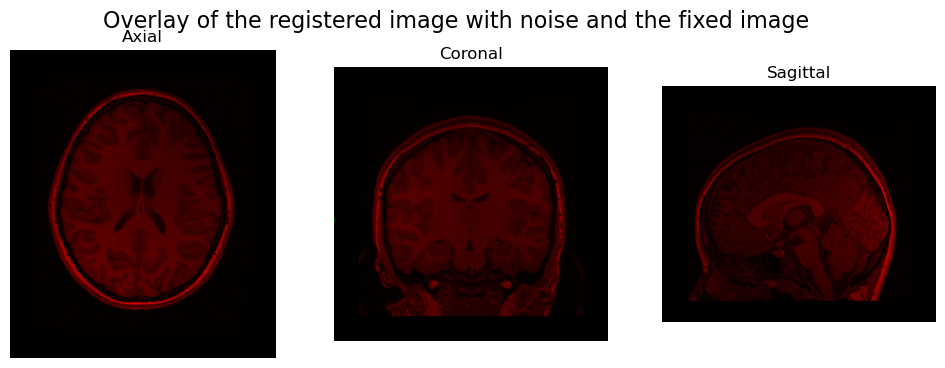

In [69]:
fixed_image = sitk.ReadImage(dir_in + 'ImgT1.nii')
moving_image = sitk.ReadImage(dir_in + 'ImgT1_A_rot_240.nii')

noise_sigma = 200
moving_image_noisy = sitk.AdditiveGaussianNoise(moving_image, mean=0, standardDeviation=noise_sigma)

# Set the registration method
R = sitk.ImageRegistrationMethod()
# Set the metric
R.SetMetricAsMeanSquares()

# Set the optimizer
R.SetOptimizerAsPowell(stepLength=200, numberOfIterations=10)

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.10)

# Set the pyramid scheule
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the initial transform
R.SetInterpolator(sitk.sitkLinear)

# Some extra functions to help with the iteration
R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

# Set the initial transform 
initTransform =sitk.CenteredTransformInitializer(fixed_image, moving_image_noisy, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)
R.SetInitialTransform(initTransform, inPlace=False)

# Execute the registration
tform_reg = R.Execute(fixed_image, moving_image_noisy)

params = tform_reg.GetParameters()
angles = params[:3]
print('Estimated rotation (deg) for ImgT1.nii: ')
print(np.round(np.rad2deg(angles), 3))

img_tmp = sitk.Resample(moving_image_noisy, tform_reg)
overlay_slices(fixed_image, img_tmp, title='Overlay of the registered image with noise and the fixed image')

By using the pyramidal multi-resolution registration strategy, we can make the registration of the noisy moving image to the fixed image more robust. Here we use the Gaussian pyramid procedure where we keep the image resolution (i.e., the shrink factor) in the different steps of the pyramid but introduce blurring by using a Gaussian filter at different levels. At the highest level most blurring is added, and we only see the coarse details in the image to be registered. Then, we go to finer and finer levels of details by reducing the blurring factor. The pyramidal procedure is implemented in the registration function and typically three levels are used and we just set the sigma = [3.0, 1.0, 0.0].

**Exercise 12:** Register the noisy moving image using the pyramidal procedure. Try three levels of setting sigma=[3.0, 1.0, 0.0]. Repeat the registration procedure with different step lengths. Does the image registration become more insensitive to the step length? If not try increasing sigma=[5.0, 1.0, 0.0]. Can one use only 2 levels of the pyramid? What do you suggest of sigma values? Show the optimal affine matrices for each of the repeats to check robustness.

  0 =   36.06373 : (800.0575977826124, -0.0002544018478896553, 0.00012756824216951672, -0.000788244838374793, -0.010060114460198106, -0.024571353812028993)
  1 =   36.06367 : (400.0287988913062, -0.00012720092394482766, 8.275007307410598e-05, -0.0012413859771634025, -0.0028873169800126127, -0.012285676906014497)
  0 =  739.10447 : (400.0295194047584, 0.0002787675988166738, 0.00014850883341986691, 0.007521738256089218, 0.017246906703612067, -0.012265351156275939)
  0 = 11910.17973 : (400.024099871631, -0.001810436698275742, -0.0016189637309710714, 0.0955308747528605, -0.1731694033782325, -0.0436857248458389)
  1 = 11903.36521 : (400.0254315459259, 0.00016025751284659876, -0.0007490699030861313, 0.06176568892441761, -0.07453265794107318, -0.06378047143647576)
  2 = 11903.09264 : (400.0260305278788, -0.0002929438673503644, -0.0007721420550666626, 0.05694275093020428, -0.07951767997713506, -0.06279081722166999)
  3 = 11903.05693 : (400.0260305278788, -0.0003232392255685099, -0.000834505698

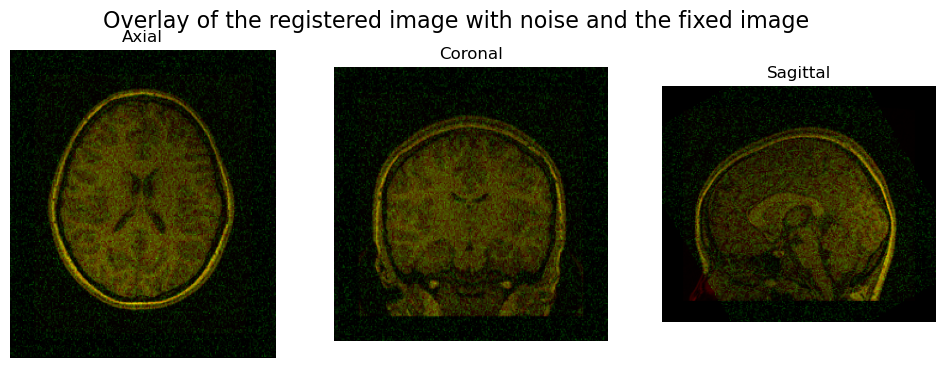

In [70]:
noise_sigma = 200
moving_image_noisy = sitk.AdditiveGaussianNoise(moving_image, mean=0, standardDeviation=noise_sigma)

# Set the registration method
R = sitk.ImageRegistrationMethod()
# Set the metric
R.SetMetricAsMeanSquares()

# Set the optimizer
R.SetOptimizerAsPowell(stepLength=200, numberOfIterations=10) # stepLength= 10, 50, 150, 200

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.10)

# Set the pyramid scheule
R.SetShrinkFactorsPerLevel(shrinkFactors = [2,2,2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[3,1,0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the initial transform
R.SetInterpolator(sitk.sitkLinear)

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.10)

# Some extra functions to help with the iteration
R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

# Set the initial transform
initTransform =sitk.CenteredTransformInitializer(fixed_image, moving_image_noisy, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)
# initTransform = sitk.Euler3DTransform()
R.SetInitialTransform(initTransform, inPlace=False)

# Execute the registration
tform_reg = R.Execute(fixed_image, moving_image_noisy)

params = tform_reg.GetParameters()
angles = params[:3]
print('Estimated rotation (deg) for ImgT1.nii: ')
print(np.round(np.rad2deg(angles), 3))

img_tmp = sitk.Resample(moving_image_noisy, tform_reg)
overlay_slices(fixed_image, img_tmp, title='Overlay of the registered image with noise and the fixed image')